In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [29]:
model = tf.keras.applications.resnet_v2.ResNet50V2(include_top=True,weights='imagenet')
model.trainable = False
decode_predictions = tf.keras.applications.resnet_v2.decode_predictions

In [30]:
def preprocess(image):
    img = tf.keras.preprocessing.image.load_img(image, target_size=(224, 224))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    img = img[None,...]
    return img

In [31]:
img = 'cat.jpg'
img = preprocess(img)

pred = model.predict(img)
lab = decode_predictions(pred,top=1)[0][0][1]
conf = decode_predictions(pred,top=1)[0][0][2]
print(lab)
print(conf*100)
print('Index of label = {}'.format(pred.argmax()))

Egyptian_cat
43.87916326522827
Index of label = 285


<function matplotlib.pyplot.show(close=None, block=None)>

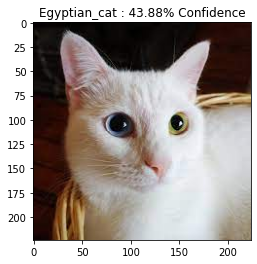

In [32]:
plt.imshow(tf.keras.preprocessing.image.load_img('cat.jpg', target_size=(224, 224)))
plt.title('{} : {:.2f}% Confidence'.format(lab, conf*100))
plt.show

In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def get_gradient(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  return gradient

def get_momentum(gradient):
  denominator = tf.norm(gradient, ord=1)
  denominator = denominator.numpy()
  momentum = gradient / denominator
  return momentum

In [34]:
def display_images(image, description):
  pred = model.predict(image)
  lab = decode_predictions(pred,top=1)[0][0][1]
  conf = decode_predictions(pred,top=1)[0][0][2]
  plt.figure()
  plt.imshow(image[0]*0.5+0.5)
  plt.title('{} \n {} : {:.4f}% Confidence'.format(description, lab, conf*100))
  plt.show()

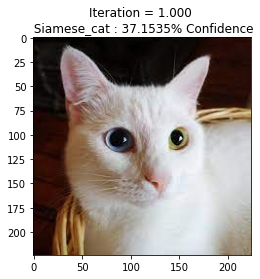

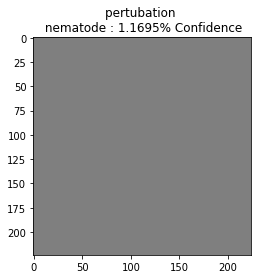

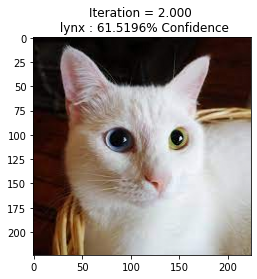

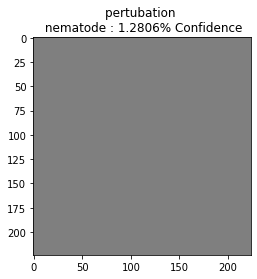

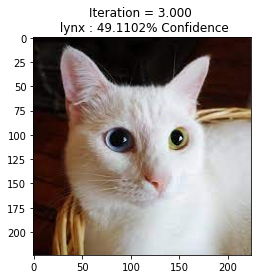

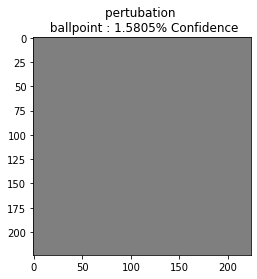

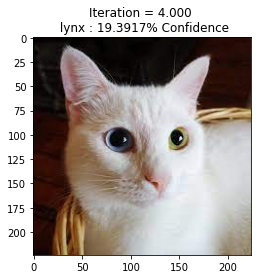

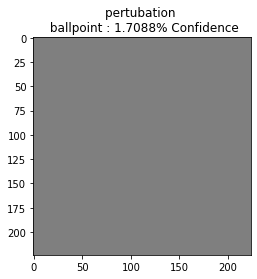

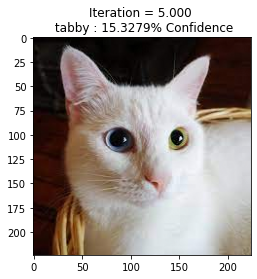

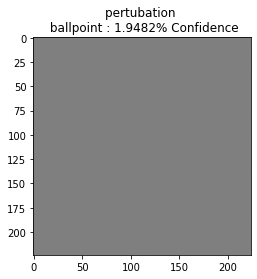

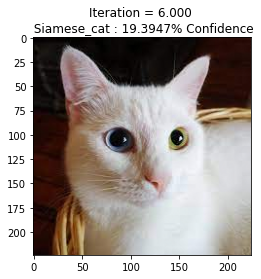

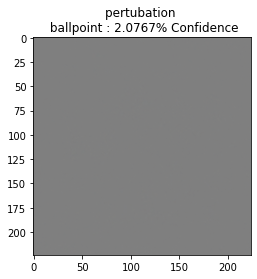

In [35]:
adv_x = img
momentum = 0
decay = 1.2
eps = 0.005
t = 6
alpha = eps/t
descriptions = [('Iteration = {:0.3f}'.format(i+1)) for i in range(0,1000)]


for i in range(0,t):
  
  #current prediction
  pred = model.predict(adv_x)
  
  #getting label of true class
  label_index = pred.argmax()
  label = tf.one_hot(label_index, pred.shape[-1])
  label = tf.reshape(label, (1, pred.shape[-1]))

  #getting momentum update value for t timestamp
  gradient_val = get_gradient(img, label)
  momentum_val = get_momentum(gradient_val[0])

  #updating our momentum for t timestamp
  momentum = decay*momentum + momentum_val

  #getting sign of momentum for t timestamp
  sign = tf.sign(momentum)

  #updating adversarial example
  adv_x = adv_x + (alpha*sign)
  adv_x = tf.clip_by_value(adv_x, -1, 1)

  #displaying final adversarial example
  #if (i==t-1):
  display_images(adv_x, descriptions[i])
  display_images(adv_x - img, 'pertubation')